### Spatial mapping of human lung region snRNA-seq to Visium (for Elo) - with scVI non-amortised inference

In [1]:
import sys
#sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

import scanpy as sc
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
#import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

Global seed set to 0


`THEANO_FLAGS='force_device=True'` forces the package to use GPU. Pay attention to error messages that might indicate theano failed to initalise the GPU.   
Do not forget to change `device=cuda4` to your available GPU id. Use `device=cuda` / `device=cuda0` if you have just one locally or if you are requesting one GPU via HPC cluster job.

### Outline

1. Loading Visium data and single cell reference
2. Show UMAP of cells and locations
3. cell2location analysis in one step
4. Automatic discrete region identification by clustering cell densities
5. Visualize cell type density gradients using diffusion maps
6. Identify co-occuring cell type combinations using matrix factorisation



## 1. Loading Visium data and single cell reference

First let's read spatial Visium data from 10X Space Ranger output. Here we load sample annotations.

In [2]:
#sp_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/regions_with_visium_all/'
sp_data_folder = '/lustre/scratch117/cellgen/team205/sharedData/em17/visium-ffpe/'
sc_data_folder = '/nfs/team205/vk7/sanger_projects/large_data/lung_airway_km/'
results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results/'
gut_results_folder = '/nfs/team205/vk7/sanger_projects/collaborations/fetal_gut_mapping/results/'
scvi_ref_run_name = f'{results_folder}/non_amortised/v0_Adam_4000iter_snsc_selection_CCLplasma_ref'
scvi_gut_ref_run_name = f'{gut_results_folder}regression_model/v1_ye_signatures_lr0002_Adam'

scvi_run_name = f'{results_folder}/non_amortised/v3_nonamortised_Adam_alpha20_40k_lr0002_CCLplasma_long_ref_wo_lowQ_gutFDC_GC_VisiumFFPE'

annotation_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/Loupe_annotations_FFPE/'

sample_name = pd.Series(['WSA_LngSP10972072', 'WSA_LngSP10972073', 'WSA_LngSP10972074', 'WSA_LngSP10972075', 
                        ])
image_folder = '/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/data/original_histology/Images_16/'

# path for plots
fig_path = f'{scvi_run_name}/plots/figures/'
fig_path

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results//non_amortised/v3_nonamortised_Adam_alpha20_40k_lr0002_CCLplasma_long_ref_wo_lowQ_gutFDC_GC_VisiumFFPE/plots/figures/'

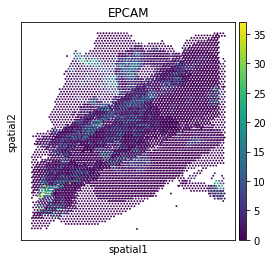

In [3]:
adata_vis = sc.read_h5ad(f'{scvi_run_name}/sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

# plot everything to get rid of warnings later
sc.pl.spatial(adata_vis, 
              color=["EPCAM"], img_key=None,
              vmin=0, library_id='WSA_LngSP10972072',
              gene_symbols='SYMBOL'
             )

## Spatial plots per cell type

Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.
Trying to set attribute `.uns` of view, copying.


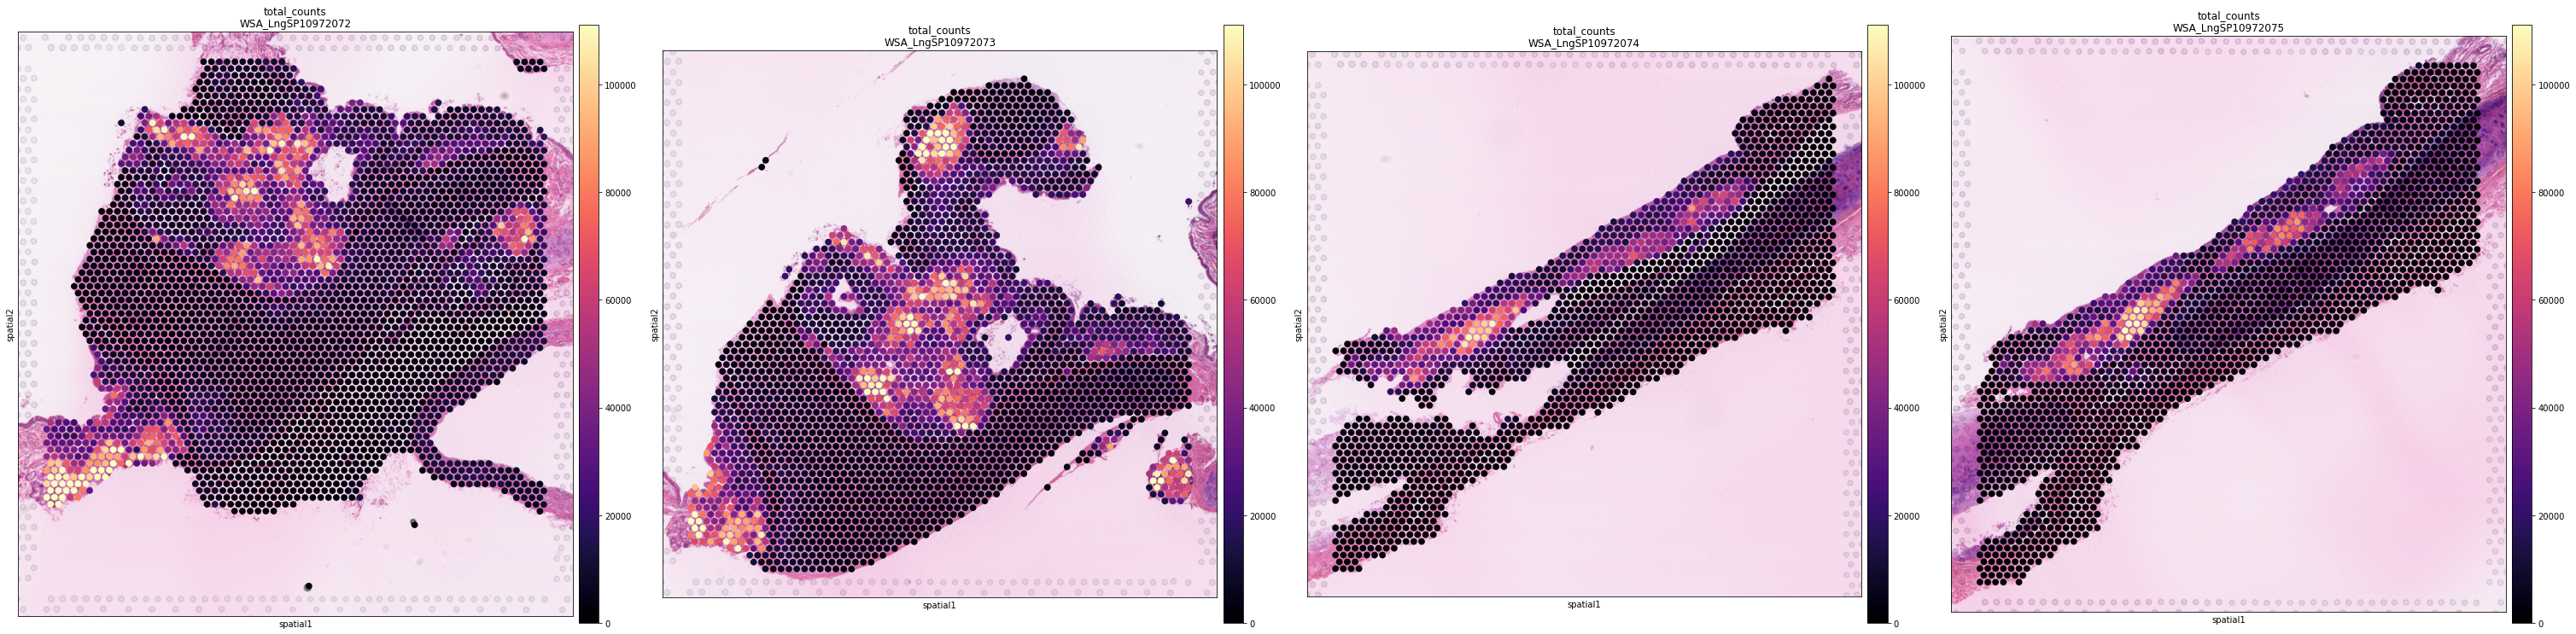

In [4]:
# defining useful function
def select_slide(adata, s, s_col='sample'):
    r""" Select data for one slide from the spatial anndata object.

    :param adata: Anndata object with multiple spatial samples
    :param s: name of selected sample
    :param s_col: column in adata.obs listing sample name for each location
    """

    slide = adata[adata.obs[s_col].isin([s]), :]
    s_keys = list(slide.uns['spatial'].keys())
    s_spatial = np.array(s_keys)[[s in k for k in s_keys]][0]

    slide.uns['spatial'] = {s_spatial: slide.uns['spatial'][s_spatial]}

    return slide

# identify spot locations to crop near tissue
def get_crop_coord(slide, scale='tissue_hires_scalef'):

    crop_max = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors'][scale]).max(axis=0)
    crop_min = (slide.obsm['spatial'] * list(slide.uns['spatial'].values())[0]['scalefactors'][scale]).min(axis=0)

    crop_x = [crop_min[0]-0, crop_max[0]+0]
    crop_y = [crop_min[1]-0, crop_max[1]+0]

    return crop_x, crop_y
    

def plot_spatial_per_cell_type(adata, 
                               cell_type='total_counts',
                               samples=[
       'WSA_LngSP10972072', 'WSA_LngSP10972073', 'WSA_LngSP10972074',
                                    
       'WSA_LngSP10972075',
                               ],
                              ncol=4, prefix='', figsize=(42, 10),
                              vmax_quantile=0.992):
    n_samples = len(samples)
    nrow = int(np.ceil(n_samples / ncol))
    fig, axs = plt.subplots(nrow, ncol, figsize=figsize)
    if nrow == 1:
        axs = axs.reshape((1, ncol))
    
    col_name = f'{prefix}{cell_type}'
    vmax = np.quantile(adata_vis.obs[col_name].values, vmax_quantile)
    adata_vis.obs[cell_type] = adata_vis.obs[col_name].copy()
    
    from itertools import chain
    ind = list(chain(*[[(i, j) for i in range(nrow)] for j in range(ncol)]))
    
    for i, s in enumerate(samples):
        sp_data_s = select_slide(adata, s, s_col='sample')
        sc.pl.spatial(sp_data_s, cmap='magma',
                      color=cell_type, 
                      size=1.3, img_key='hires', alpha_img=1,
                      vmin=0, vmax=vmax, ax=axs[ind[i][0],ind[i][1]], show=False
                                            )
        axs[ind[i][0],ind[i][1]].title.set_text(cell_type+'\n'+s)
        
    if len(samples) < len(axs.flatten()):
        for i in range(len(samples), len(axs.flatten())):
            axs[ind[i][0],ind[i][1]].axis('off')
        
    fig.tight_layout(pad=0.5)
        
    return fig

plot_spatial_per_cell_type(adata_vis, cell_type='total_counts');

List cell type names

In [5]:
adata_vis.uns['mod']['factor_names']#.to_csv('./factor_names')

array(['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA',
       'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4', 'CD4_TRM',
       'CD4_naive/CM', 'CD8', 'CD8_CTL', 'CD8_GZMK+', 'CD8_TRM',
       'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2', 'DC_activated',
       'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2',
       'Dividing_Basal', 'Endothelia_Lymphatic',
       'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
       'Endothelia_vascular_arterial_pulmonary',
       'Endothelia_vascular_arterial_systemic',
       'Endothelia_vascular_venous_pulmonary',
       'Endothelia_vascular_venous_systemic', 'Erythrocyte', 'Fibro_ASPN',
       'Fibro_adventitial', 'Fibro_adventitial_CCL', 'Fibro_alveolar',
       'Fibro_peribronchial', 'Fibro_perichondrial', 'ILC',
       'Ionocyte_n_Brush', 'MAIT', 'Macro_CHIT1', 'Macro_CXCL10',
       'Macro_MARCOneg_FCGBP_Trachea', 'Macro_MARCOpos_Metallothioneins',
       'Macro_alv', 'Macro_dividing', 'Macro_int', 'Macro_int_CCL',
       'Mast

### Multi-colour spatial plot

### Dotplot by histology-based annotation

In [6]:
# read histology-based annotations:
from glob import glob
from re import sub
annotations = []
for s in adata_vis.obs['sample'].unique():
    annotation_files = glob(f'{annotation_folder}{s}/*csv')
    annotation_cols = [sub('^.+/', '', i)for i in annotation_files]
    annotation_cols = [sub('\.csv$', '', i)for i in annotation_cols]
    annotation_cols_clean = [sub(' ', '_', i)for i in annotation_cols]
    annotations = annotations + annotation_cols_clean

    for i, f in enumerate(annotation_files):
        
        annot_ = pd.read_csv(f, index_col='Barcode')
        annot_.index = [f'{s}_{i}' for i in annot_.index]
        
        if annotation_cols_clean[i] not in adata_vis.obs.columns:
            adata_vis.obs[annotation_cols_clean[i]] = ''

        adata_vis.obs.loc[annot_.index, annotation_cols_clean[i]] = annot_[annotation_cols[i]]
    
annotations = np.unique(annotations)
adata_vis.obs['Tissue'].value_counts(dropna=False)#, adata_vis.obs['Weird_morphology'].value_counts(dropna=False), annotations

1.0    7202
       1768
NaN     123
Name: Tissue, dtype: int64

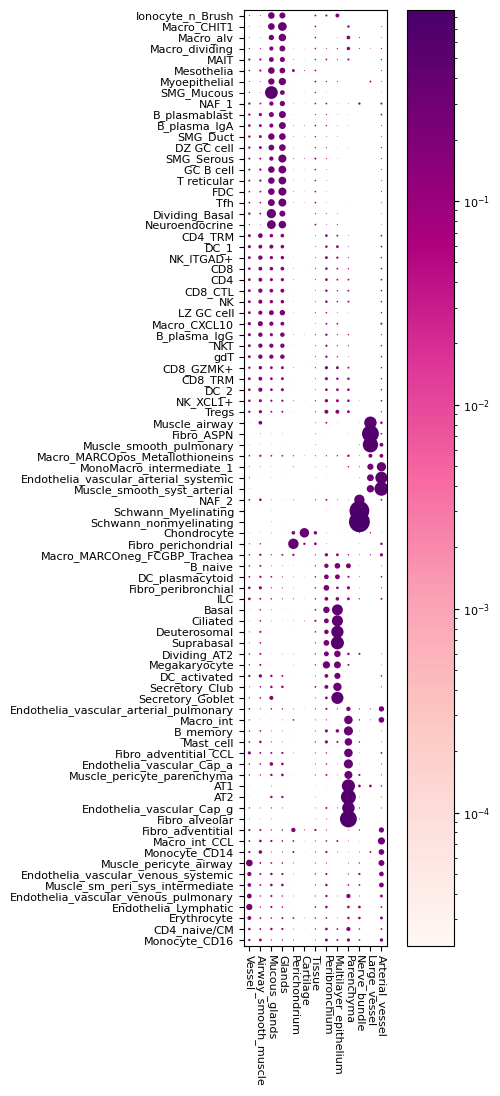

In [8]:
fig_dir = f'{scvi_run_name}/plots/'

annot_ = annotations#['Tissue', 'Perichondrium', 'Cartilage', 'Glands',
       #'Multilayer_epithelium', 'Airway_Smooth_Muscle', 'Weird_morphology',
       #'Nerve', 'Venous_vessel', 'Arterial_vessel', 'Parenchyma',
       #'Mesothelium', 'Pulmonary_vessel', 'Small_airway', 'iBALT']

annot_abundance_df = pd.DataFrame(index=adata_vis.uns['mod']['factor_names'],
                                  columns=annot_)
for a in annot_:
    ind = adata_vis.obs[a] == 1.0
    annot_abundance_df[a] = adata_vis.obs.loc[ind, adata_vis.uns['mod']['factor_names']].mean(0)
    
annot_abundance_norm = (annot_abundance_df.T / annot_abundance_df.sum(1)).T

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 8, 'axes.facecolor': "white"}):
    from cell2location.plt.plot_heatmap import clustermap
    clustermap(annot_abundance_norm, figure_size=(5, 11), 
               cmap='RdPu', log=True, fun_type='dotplot',
               cluster_rows=True, cluster_cols=True)
    plt.savefig(f"{fig_dir}histology_annotation_dotplot.pdf",
                    bbox_inches='tight')
    plt.show()

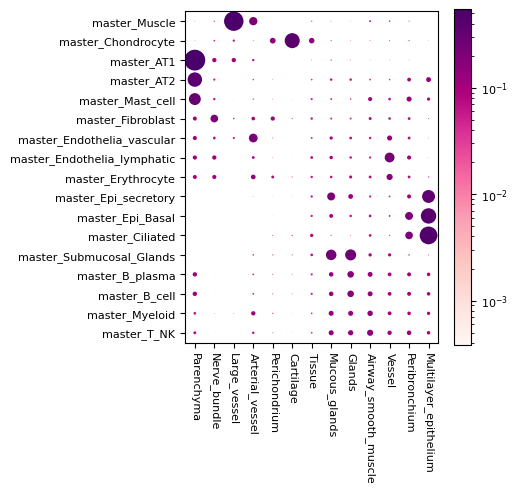

'/nfs/team205/vk7/sanger_projects/collaborations/adult_lung_mapping/results//non_amortised/v3_nonamortised_Adam_alpha20_40k_lr0002_CCLplasma_long_ref_wo_lowQ_gutFDC_GC_VisiumFFPE/plots/'

In [9]:
adata_ref = sc.read_h5ad(f'{scvi_ref_run_name}/sc.h5ad')
adata_ref.obs.columns[['aster' in i for i in adata_ref.obs.columns]]

for m in adata_ref.obs['Celltypes_master_high'].unique():
    
    ind = adata_ref.obs['Celltypes_master_high'] == m
    child = adata_ref.obs['Celltypes_int_F'][ind].unique()
    adata_vis.obs[f'master_{m}'] = adata_vis.obs[child].sum(1).values.flatten()
    
factor_names_master = [f'master_{m}' for m in adata_ref.obs['Celltypes_master_high'].unique()]

fig_dir = f'{scvi_run_name}/plots/'

annot_ = annotations#['Cartilage', 'Glands', 'Multilayer_epithelium', 
         # 'Airway_Smooth_Muscle', 'Arterial_vessel', 
         # 'Parenchyma', 'iBALT']

annot_abundance_df = pd.DataFrame(index=factor_names_master,
                                  columns=annot_)
for a in annot_:
    ind = adata_vis.obs[a] == 1.0
    annot_abundance_df[a] = adata_vis.obs.loc[ind, factor_names_master].mean(0)
    
annot_abundance_norm = (annot_abundance_df.T / annot_abundance_df.sum(1)).T

mpl.rc_file_defaults()
mpl.rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
with mpl.rc_context({'font.size': 8, 'axes.facecolor': "white"}):
    from cell2location.plt.plot_heatmap import clustermap
    clustermap(annot_abundance_norm, figure_size=(5, 5), 
               cmap='RdPu', log=True, fun_type='dotplot',
               cluster_rows=True, cluster_cols=True)
    plt.savefig(f"{fig_dir}histology_annotation_dotplot_master.pdf",
                    bbox_inches='tight')
    plt.show()
    
fig_dir

In [15]:
adata_vis.uns['mod']['factor_names'], adata_vis.uns['mod']['factor_names'].shape

(array(['AT1', 'AT2', 'B_memory', 'B_naive', 'B_plasma_IgA',
        'B_plasma_IgG', 'B_plasmablast', 'Basal', 'CD4', 'CD4_TRM',
        'CD4_naive/CM', 'CD8', 'CD8_CTL', 'CD8_GZMK+', 'CD8_TRM',
        'Chondrocyte', 'Ciliated', 'DC_1', 'DC_2', 'DC_activated',
        'DC_plasmacytoid', 'Deuterosomal', 'Dividing_AT2',
        'Dividing_Basal', 'Endothelia_Lymphatic',
        'Endothelia_vascular_Cap_a', 'Endothelia_vascular_Cap_g',
        'Endothelia_vascular_arterial_pulmonary',
        'Endothelia_vascular_arterial_systemic',
        'Endothelia_vascular_venous_pulmonary',
        'Endothelia_vascular_venous_systemic', 'Erythrocyte', 'Fibro_ASPN',
        'Fibro_adventitial', 'Fibro_adventitial_CCL', 'Fibro_alveolar',
        'Fibro_peribronchial', 'Fibro_perichondrial', 'ILC',
        'Ionocyte_n_Brush', 'MAIT', 'Macro_CHIT1', 'Macro_CXCL10',
        'Macro_MARCOneg_FCGBP_Trachea', 'Macro_MARCOpos_Metallothioneins',
        'Macro_alv', 'Macro_dividing', 'Macro_int', 'Macro_int_CC

Trying to set attribute `.uns` of view, copying.
... storing 'image_name_i' as categorical


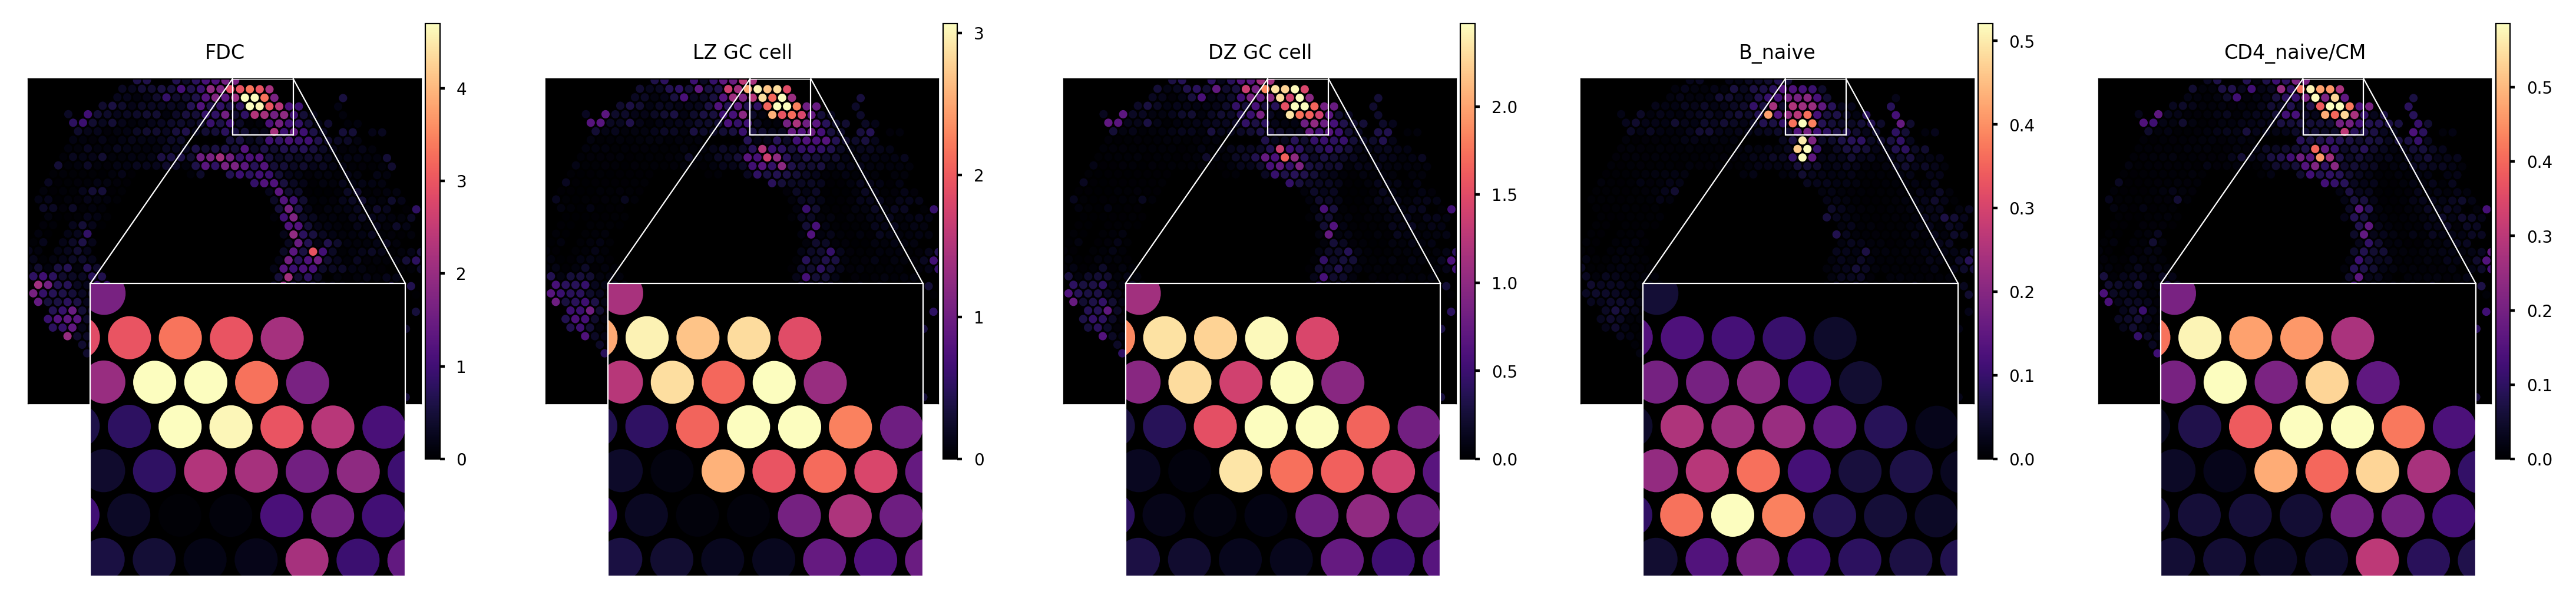

In [32]:
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes as inset_axes_func


def add_rectange_to_axis(ax, crop_coord, **kwargs):
    width = crop_coord[1] - crop_coord[0]
    height = crop_coord[2] - crop_coord[3]
    bottom_left = (crop_coord[0], crop_coord[3])
    
    kwargs = {'linewidth': 3,
             'edgecolor': 'r',
             'facecolor': 'none',
             'zorder': 10,
             **kwargs}
    
    rect = patches.Rectangle(bottom_left, width, height, **kwargs)
    ax.add_patch(rect)
    

def add_rectangle_to_fig(fig, crop_coord, **kwargs):
    if type(fig) is list:
        axs = fig
    else:
        axs = fig.axes
    for ax in axs:
        if type(ax.get_aspect()) is str or ax.get_aspect() < 5:
            add_rectange_to_axis(ax, crop_coord, **kwargs)

def spatial_with_insets(adata, ct_list, axs=None, crop_tissue=None, crop_inset=None, 
                        hires_scalef=1, mode='lines', linewidth=2.5, quantile=0.997):
    for col, ax in zip(ct_list, axs):
        
        vmax = np.quantile(adata.obs[col].values, quantile)
        
        fig = sc.pl.spatial(adata, cmap='magma',
                      color=col, ncols=4, 
                      size=1.3, img_key='hires', alpha_img=0,
                      frameon=True, legend_fontsize=8,
                      crop_coord=crop_tissue*hires_scalef,
                      vmin=0, vmax=vmax, 
                      show=False, ax=ax)

        ax.set_xlabel('')
        ax.set_ylabel('')
    #     ax.set_title('')

        axins = ax.inset_axes([0.04, -0.53, 0.92, 0.9])

        sc.pl.spatial(adata, cmap='magma',
                  color=col, ncols=4, 
                  size=1.3, img_key='hires', 
                  alpha_img=0,
                  frameon=True, legend_fontsize=8,
                  crop_coord=crop_inset * hires_scalef,
                  vmin=0, vmax=vmax,
                  show=False, ax=axins
                     )

        axins.set_xlabel('')
        axins.set_ylabel('')
        axins.set_title('')
        axins.collections[-1].colorbar.remove()
        plt.setp(axins.spines.values(), linewidth=linewidth, color='white', alpha=1, visible=True)
        
        if mode == 'lines':
            axins.invert_yaxis()
            _, lines = ax.indicate_inset_zoom(axins, edgecolor="white", alpha=1, linewidth=linewidth)
            axins.invert_yaxis()

            for line in lines:
                line._linewidth = linewidth
            
        elif mode == 'rect':
            add_rectangle_to_fig(fig, crop_inset,
                     edgecolor='white', linestyle='--', linewidth=linewidth)

slide = select_slide(adata_vis, 'WSA_LngSP10193348')
crop_x, crop_y = get_crop_coord(slide, scale='tissue_lowres_scalef')
crop_y = [8000, 15500]
crop_tissue = np.array(crop_x + crop_y)
crop_inset = np.array([17900, 19300, 8000, 9300])
hires_scalef = 1/slide.uns['spatial']['WSA_LngSP10193348']['scalefactors']['tissue_hires_scalef']

ct_list = ['FDC', 'LZ GC cell', 'DZ GC cell', 'B_naive', 'CD4_naive/CM']

from re import sub

with mpl.rc_context({'axes.facecolor': 'black', 'font.size':5, 'axes.linewidth':0.4, 'ytick.major.size':1.5}):
    fig, axs = plt.subplots(1, 5, figsize=((5.48*2) * (5/4), 1.2*2), dpi=400)
    spatial_with_insets(slide, ct_list, axs=axs.flatten(), crop_tissue=crop_tissue, 
                        crop_inset=crop_inset, hires_scalef=1, mode='lines', linewidth=0.4)
    plt.savefig(f'{fig_path}lymphoid_structure_{sub("/", "", "_".join(ct_list))}.pdf', bbox_inches='tight')

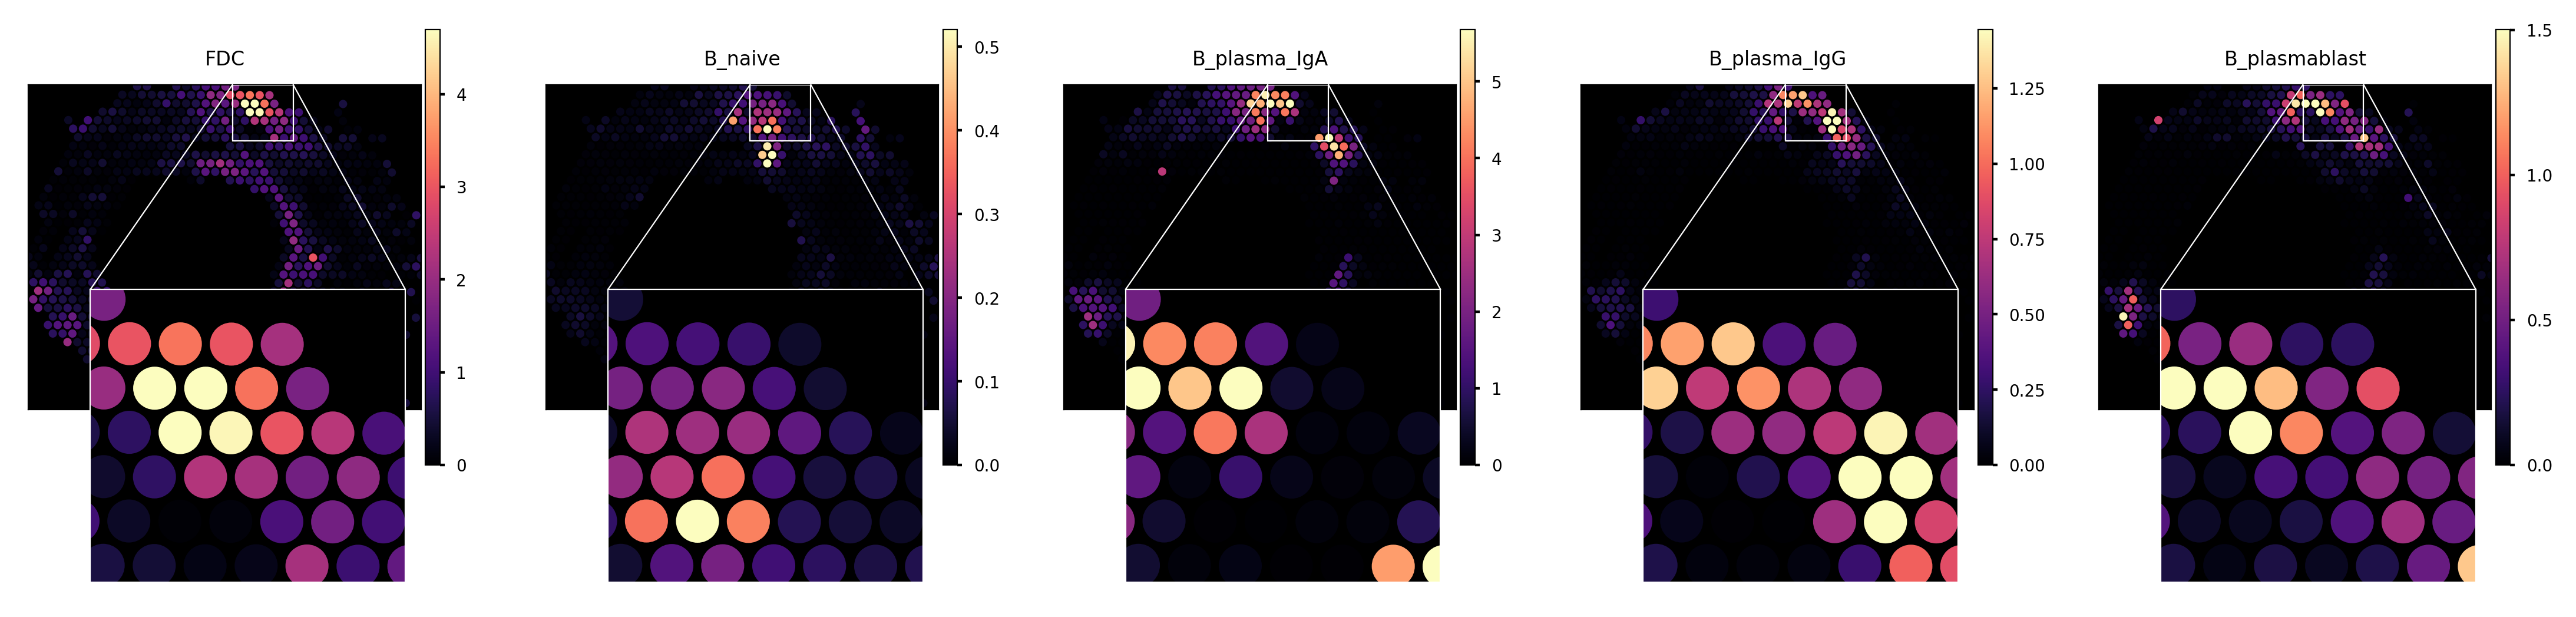

In [33]:
ct_list = ['FDC', 'B_naive', 'B_plasma_IgA', 'B_plasma_IgG', 'B_plasmablast']

with mpl.rc_context({'axes.facecolor': 'black', 'font.size':5, 'axes.linewidth':0.4, 'ytick.major.size':1.5}):
    fig, axs = plt.subplots(1, 5, figsize=((5.48*2) * (5/4), 1.2*2), dpi=400)
    spatial_with_insets(slide, ct_list, axs=axs.flatten(), crop_tissue=crop_tissue, 
                        crop_inset=crop_inset, hires_scalef=1, mode='lines', linewidth=0.4)
    plt.savefig(f'{fig_path}lymphoid_structure_{"_".join(ct_list)}.pdf', bbox_inches='tight')
    plt.savefig(f'{fig_path}lymphoid_structure_{sub("/", "", "_".join(ct_list))}.pdf', bbox_inches='tight')

Modules and their versions used for this analysis

In [ ]:
import sys
for module in sys.modules:
    try:
        print(module,sys.modules[module].__version__)
    except:
        try:
            if  type(modules[module].version) is str:
                print(module,sys.modules[module].version)
            else:
                print(module,sys.modules[module].version())
        except:
            try:
                print(module,sys.modules[module].VERSION)
            except:
                pass